# Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import LogNorm
from sklearn.cluster import DBSCAN
import scipy
import seaborn as sns
from collections import Counter
from sklearn.neighbors import NearestNeighbors # importing the library
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
earth_density    = 5.51   # [g/cm**3]

In [2]:
dataEA = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Exoplanet_Archive.csv",delimiter=",")

In [14]:
# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))
period_EA            = dataEA.pl_orbper          # [days]
radius_EA            = dataEA.pl_rade            # [Earth Radius]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.

mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature

# Luque Data
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc

pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

##### Use the Luque values for planets in that sample #### 
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] in planet_name_LI:
        LI_index              = planet_name_LI.index(planet_name_EA[i])
       
        mass_EA[i]            = mass_LI[LI_index]
        mass_unc_up_EA[i]     = mass_unc_up_LI[LI_index]
        mass_unc_low_EA[i]    = mass_unc_low_LI[LI_index]
        
        radius_EA[i]          = radius_LI[LI_index]
        radius_unc_up_EA[i]   = radius_unc_up_LI[LI_index]      
        radius_unc_low_EA[i]  = radius_unc_low_LI[LI_index]    

        density_EA[i]         = density_LI[LI_index]  
        density_unc_up_EA[i]  = density_unc_up_LI[LI_index]  
        density_unc_low_EA[i] = density_unc_low_LI[LI_index] 
        

NameError: name 'dataLI' is not defined

In [4]:
def filter_planets_no_spec(planet_name_list,star_type):
    EA_planets = []
    spectral_type = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4:
            EA_planets.append(planet_name_list[i])
            spectral_type.append(st_spectype_EA[i])
    if "M" in star_type:
    #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets,spectral_type

In [5]:
EA_planets,spectral_type = filter_planets_no_spec(planet_name_EA,"K")
#Counter(spectral_type)

# Filter Planets

In [10]:
def filter_planets(planet_name_list,rel_unc_mass_criteria,rel_unc_density_criteria,star_type):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and star_type in st_spectype_EA[i]:
            relative_uncertainty_mass    = (mass_unc_up_EA[i] - mass_unc_low_EA[i]) / (2 * mass_EA[i])
            relative_uncertainty_density = (density_unc_up_EA[i] - density_unc_low_EA[i]) / (2 * density_EA[i])
            if relative_uncertainty_mass < rel_unc_mass_criteria and relative_uncertainty_density < rel_unc_density_criteria:
                EA_planets.append(planet_name_list[i])
    if rel_unc_mass_criteria > 0.06 and rel_unc_density_criteria > 0.06 and "M" in star_type:
    #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets

def filter_planets_no_unc(planet_name_list,star_type):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and star_type in st_spectype_EA[i]:
            EA_planets.append(planet_name_list[i])
    if "M" in star_type:
    #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets

In [7]:
def make_lists(EA_planets):
    planet      = [];planet_i       = []; 
    radius      = []; radius_up     = []; radius_low  = []
    mass        = [];  mass_up      = []; mass_low    = []
    density     = []; density_up    = []; density_low = []

    for i in range(0,len(EA_planets)):
        index  = list(planet_name_EA).index(EA_planets[i]); planet.append(dataEA.pl_name[index])
        radius.append(dataEA.pl_rade[index]); radius_up.append(dataEA.pl_radeerr1[index]); radius_low.append(dataEA.pl_radeerr2[index])
        density.append(dataEA.pl_dens[index]); density_up.append(dataEA.pl_denserr1[index]); density_low.append(dataEA.pl_denserr2[index])
        mass.append(dataEA.pl_bmasse[index]); mass_up.append(dataEA.pl_bmasseerr1[index]);  mass_low.append(dataEA.pl_bmasseerr2[index])
    return index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low

def find_planet_index(name):
    return (list(EA_planets).index(name))

## Mass and Density

0


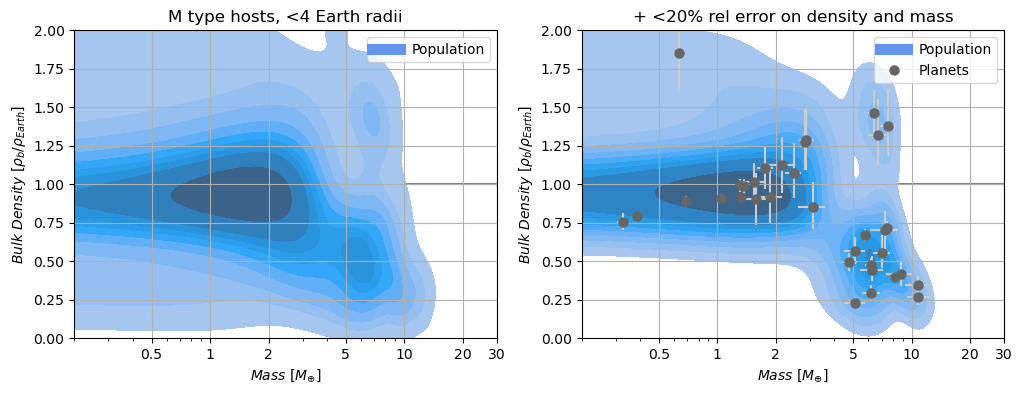

In [8]:
num_samples = 30
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

EA_planets = filter_planets_no_unc(planet_name_EA,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = np.divide(density,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
    density_upper_err = np.divide(density_up,earth_density)[i]

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True)
plt.title('M type hosts, <4 Earth radii')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False);
plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30)
plt.plot(100,100,label="Population",color = "cornflowerblue")
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

    
##### + 20% rel of density and mass ####
plt.subplot(1, 2, 2)
EA_planets = filter_planets(planet_name_EA,0.20,0.20,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = np.divide(density,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
    density_upper_err = np.divide(density_up,earth_density)[i]

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('+ <20% rel error on density and mass')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)


329


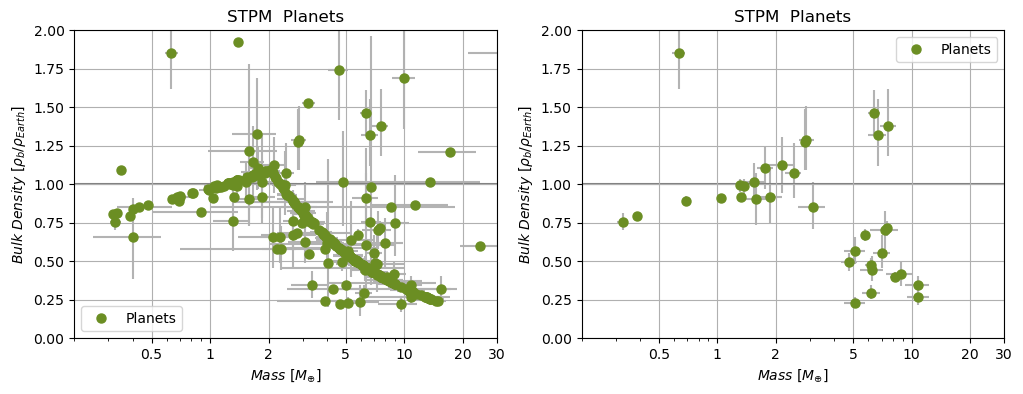

In [11]:
#### All planets smaller than 4 Earth radii and has M-type host ###
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
EA_planets = filter_planets_no_unc(planet_name_EA,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "olivedrab",markersize = 13)
plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.7",zorder=-32)

plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log"); plt.legend()
plt.title("STPM  Planets"); plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
leg = plt.legend(); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30)
print(len(mass))

#### Density-Mass restricted 20% Rel_err ####
plt.subplot(1, 2, 2)
EA_planets = filter_planets(planet_name_EA,0.20,0.20,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "olivedrab",markersize = 13)
plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.7",zorder=-32)

plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log"); plt.legend()
plt.title("STPM  Planets"); plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
leg = plt.legend(); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30)

Rel unc 15% has 16 planets
Rel unc 20% has 34 planets
Rel unc 25% has 41 planets
Rel unc 30% has 51 planets
Rel unc 35% has 55 planets


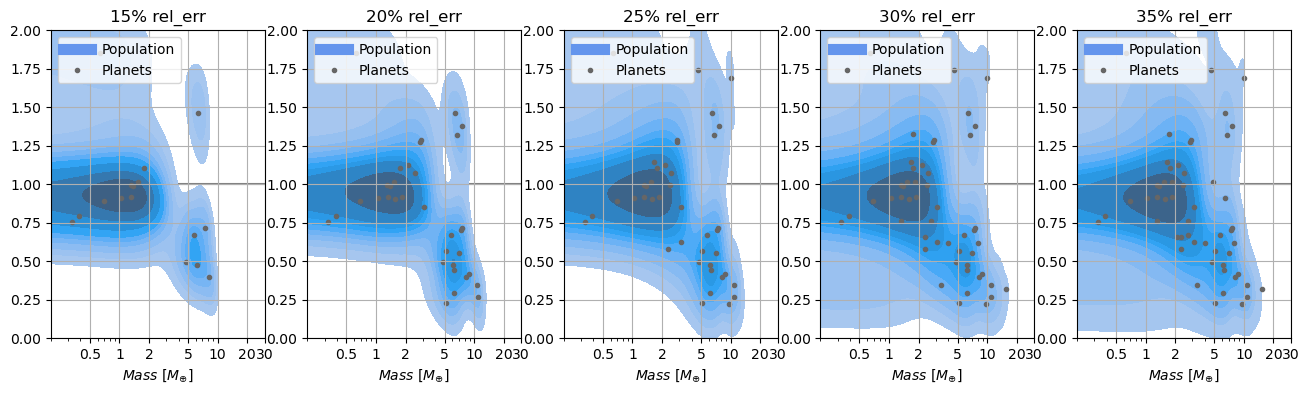

In [15]:
num_samples = 30
plot_planets = True
errorbars    = False
plt.figure(figsize=(16, 4))
mass_rel_uni    = [0.15,0.20,0.25,0.30,0.35]
density_rel_uni = [0.15,0.20,0.25,0.30,0.35]

for i in range(0,len(density_rel_uni)):
    rel_unc = mass_rel_uni[i]
    plt.subplot(1, len(density_rel_uni), i+1)
    EA_planets = filter_planets(planet_name_EA,mass_rel_uni[i],density_rel_uni[i],"M")
    index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)

    radii = []; masses = []; densitys = []
    for i in range(0,len(mass)):
        mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]

        mean_density = np.divide(density,earth_density)[i]; 
        density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
        density_upper_err = np.divide(density_up,earth_density)[i]

        # Number of posterior samples to generate
        mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
        masses.append(mass_samples)
        density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
        densitys.append(density_samples)

    masses_flattened = [item for sublist in masses for item in sublist]
    radii_flattened = [item for sublist in radii for item in sublist]
    densitys_flattened = [item for sublist in densitys for item in sublist]

    # Create a 2D density colormap plot using KDE
    sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,zorder = -10)
    plt.plot(100,100,label="Population",color = "cornflowerblue")
    mass_err         = [np.abs(mass_low),mass_up]
    density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
    if plot_planets:
        plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 6,zorder=0)
        if errorbars:
            plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=-1)
    plt.title(str(int(rel_unc*100))+'% rel_err')
    if i == 0:
            plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$");
    plt.xlabel("$Mass\ [M_{\oplus}]$");  plt.xscale("log");
    plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
    leg = plt.legend(loc='upper left')
    for line in leg.get_lines():
        line.set_linewidth(8.0)
    print("Rel unc "+str(int(rel_unc*100))+"% has "+str(len(mass))+" planets")

## MKG - planets

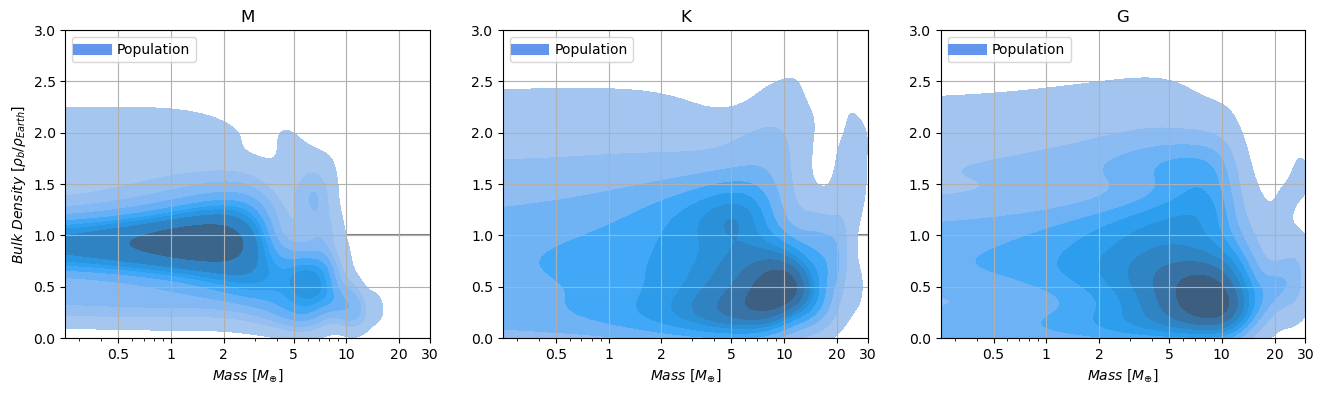

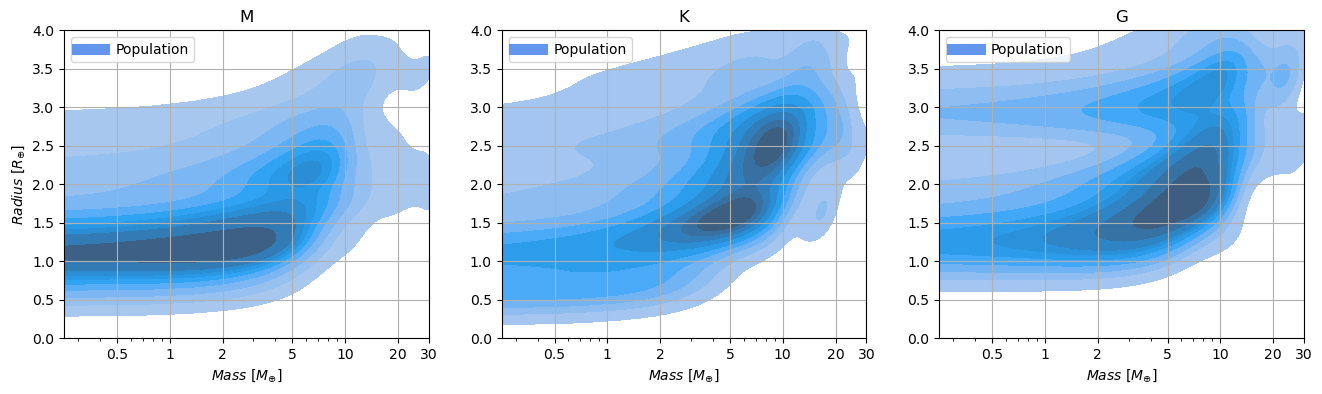

In [17]:
## num_samples = 30
plot_planets = False
errorbars    = False
plt.figure(figsize=(16, 4))
star_type = ["M","K","G"]

for j in range(0,len(star_type)):
    plt.subplot(1, len(star_type), j+1)
    EA_planets = filter_planets_no_unc(planet_name_EA,star_type[j])
    index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)

    radii = []; masses = []; densitys = []
    for i in range(0,len(mass)):
        mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]

        mean_density = np.divide(density,earth_density)[i]; 
        density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
        density_upper_err = np.divide(density_up,earth_density)[i]

        # Number of posterior samples to generate
        mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
        masses.append(mass_samples)
        density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
        densitys.append(density_samples)

    masses_flattened = [item for sublist in masses for item in sublist]
    radii_flattened = [item for sublist in radii for item in sublist]
    densitys_flattened = [item for sublist in densitys for item in sublist]

    # Create a 2D density colormap plot using KDE
    sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,zorder = -10)
    plt.plot(100,100,label="Population",color = "cornflowerblue")
    mass_err         = [np.abs(mass_low),mass_up]
    density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
    if plot_planets:
        plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 6,zorder=0)
        if errorbars:
            plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=-1)
    plt.title(star_type[j])
    if j == 0:
            plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$");
    plt.xlabel("$Mass\ [M_{\oplus}]$");  plt.xscale("log");
    plt.ylim(0,3);  plt.xlim(0.25,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
    leg = plt.legend(loc='upper left')
    for line in leg.get_lines():
        line.set_linewidth(8.0)

plt.figure(figsize=(16, 4))
for j in range(0,len(star_type)):
    plt.subplot(1, len(star_type), j+1)
    EA_planets = filter_planets_no_unc(planet_name_EA,star_type[j])
    index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)

    radii = []; masses = []; densitys = []
    for i in range(0,len(mass)):
        mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
        
        mean_density = np.divide(density,earth_density)[i]; 
        density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
        density_upper_err = np.divide(density_up,earth_density)[i]

        mean_radius = radius[i]
        radius_lower_err = np.abs(radius_low[i])
        radius_upper_err = radius_up[i]
        
        # Number of posterior samples to generate
        mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
        masses.append(mass_samples)
        
        density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
        densitys.append(density_samples)

        radius_samples = np.random.normal(mean_radius, (radius_lower_err + radius_upper_err) / 2, num_samples)
        radii.append(radius_samples)
        
    masses_flattened = [item for sublist in masses for item in sublist]
    radii_flattened = [item for sublist in radii for item in sublist]
    densitys_flattened = [item for sublist in densitys for item in sublist]

    # Create a 2D density colormap plot using KDE
    sns.kdeplot(x =masses_flattened,y=radii_flattened, fill=True,zorder = -10)
    plt.plot(100,100,label="Population",color = "cornflowerblue")
    mass_err         = [np.abs(mass_low),mass_up]
    radius_err       = [np.abs(radius_low),radius_up]
    if plot_planets:
        plt.plot(mass,radius,".",label = "Planets",color = "0.4",markersize = 6,zorder=0)
        if errorbars:
            plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=-1)
    plt.title(star_type[j])
    if j == 0:
            plt.ylabel("$Radius\ [R_{\oplus}]$"); 
    plt.xscale("log"); plt.ylim(0,4); plt.xlim(0.25,30)
    plt.xlabel("$Mass\ [M_{\oplus}]$");  plt.grid(); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False);
    leg = plt.legend(loc='upper left')
    for line in leg.get_lines():
        line.set_linewidth(8.0)